# Objective: fine-tuning DETR
-   Official DETR repository: https://github.com/facebookresearch/detr

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.1.1 False


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [3]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [4]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
#import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Fine-tuning

In [5]:
num_classes = 2
finetuned_classes = ['Metal', 'Wooden']

## Loading fine-tuned model

In [6]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('models/checkpoint_Q1.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /Users/sunwoo/.cache/torch/hub/facebookresearch_detr_main
/Users/sunwoo/opt/anaconda3/envs/streetwatch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sunwoo/opt/anaconda3/envs/streetwatch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
min_area = 10000 # for standard 90 fov
#min_area = 15000 # for 45 fov?
min_height = 250

print("Bounding Box Area:", min_area)
print("Min Height ", min_height)

Bounding Box Area: 10000
Min Height  250


In [34]:
#!pip install psycopg2

In [11]:
import psycopg2

conn = psycopg2.connect(
    host = 'localhost',
    database='mydatabase',
    user = 'dsc180b',
    password = 'dsc180b'
)

cur = conn.cursor()

OperationalError: could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?


In [36]:
cur.execute(
    '''
    CREATE TABLE mypoles (
        id SERIAL PRIMARY KEY,
        latitude DOUBLE PRECISION,
        longitude DOUBLE PRECISION,
        type VARCHAR(6)
    )
    '''
)

In [49]:
def filterOverlappingBox(prob, bbox, threshold = 0.3):
    def isOverlapping2D(box1, box2):
        def isOverlapping1D(xmin1, xmax1,xmin2, xmax2):
            return xmin1 <= xmax2 and xmin2 <= xmax1
        xmin1, ymin1, xmax1, ymax1 = box1
        xmin2, ymin2, xmax2, ymax2 = box2

        return isOverlapping1D(xmin1, xmax1,xmin2, xmax2) and isOverlapping1D(ymin1, ymax1,ymin2, ymax2)

    def overlappingArea(box1,box2):
        def overlappingLine(xmin1, xmax1,xmin2, xmax2):
            return min(xmax1, xmax2) - max(xmin1,xmin2)
        xmin1, ymin1, xmax1, ymax1 = box1
        xmin2, ymin2, xmax2, ymax2 = box2
        return overlappingLine(xmin1, xmax1,xmin2, xmax2)*overlappingLine(ymin1, ymax1,ymin2, ymax2)

    def boxArea(box):
        xmin, ymin, xmax, ymax = box
        return (xmax-xmin)*(ymax-ymin)
    
    i=0
    j=1
    removed =[]
    while(i<len(bbox)-1):
        if i in removed or j>= len(bbox):
            i += 1
            j = i+1
            continue
        if j in removed:
            j +=1
            continue
        box1 = bbox[i]
        box2 = bbox[j]
        if isOverlapping2D(box1, box2):
            area1 = boxArea(box1)
            area2 = boxArea(box2)
            areaO = overlappingArea(box1,box2)
            if (areaO/area1)>threshold or (areaO/area2)>threshold:
                p1 = prob[i]
                p2 = prob[2]

                if p1.max()<p2.max():
                    removed += [i]
                else:
                    removed += [j]    
        j+=1

    out_prob = []
    out_bbox = []
    for i in range(len(bbox)):
        if i not in removed:
            out_prob += [prob[i]]
            out_bbox += [bbox[i]]
    return out_prob,out_bbox

In [46]:
def run_worflow(my_image, my_model, img_name):
      # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.5]:

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)
    probas_to_keep, bboxes_scaled = filterOverlappingBox(probas_to_keep, bboxes_scaled)
    
    if probas_to_keep is not None and bboxes_scaled is not None:
        for p, (xmin, ymin, xmax, ymax)in zip(probas_to_keep, bboxes_scaled):
            cl = p.argmax()
            
            img_split = img_name.split('_')
            """
            latitude = img_split[2]
            longitude = img_split[3][:-4]
            pole_type = finetuned_classes[cl]
            
            cur_area = (xmax - xmin) * (ymax - ymin)
            print(cur_area)
            cur_height = ymax - ymin
            """
            """
            if cur_area > min_area:
            #if height > min_height:
                insert_query = f" \
                INSERT INTO mypoles (latitude, longitude, type) VALUES \
                ({latitude}, {longitude}, '{pole_type}') \
                "
                
                cur.execute(insert_query)
                
                print(True)
            """

    plot_finetuned_results(my_image,
                           probas_to_keep,
                           bboxes_scaled)
    return probas_to_keep, bboxes_scaled


### With a training image

In [10]:
from PIL import Image
import glob

import re

# To sort images because it was doing left0, left1, left10, instead of left0, left1, left2
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

0
3
../temp/Sunny_metal_0000_0_40 copy.jpg


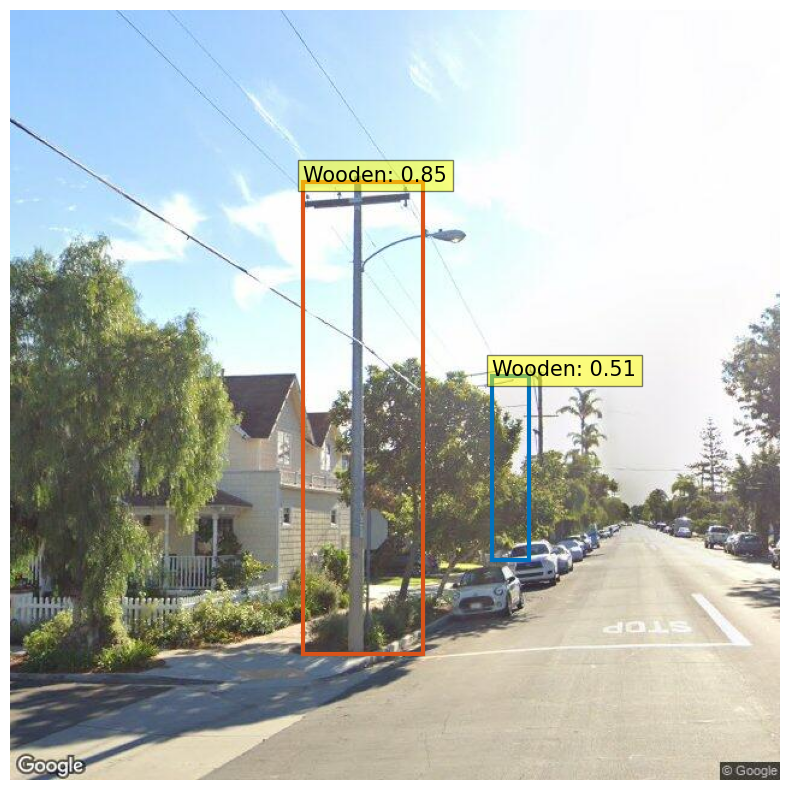

../temp/Sunny_wooden_0006_1_90 copy.jpg


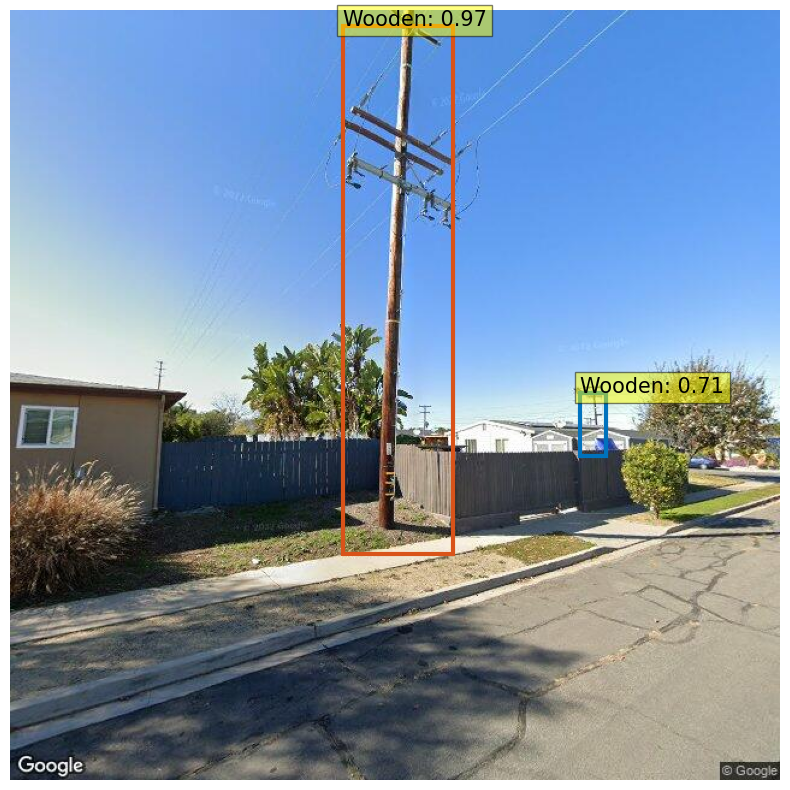

../temp/Sunny_wooden_0008_3_90 copy.jpg


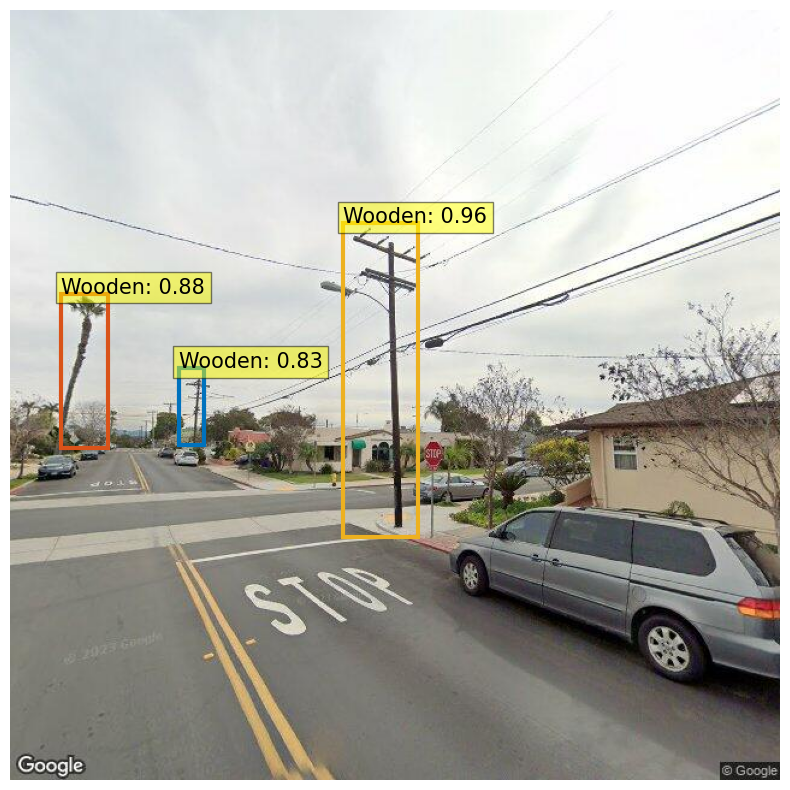

In [50]:
image_paths = glob.glob('../temp/*.jpg')
left_images = []
right_images = []

for image in image_paths:
    if '-' in image:
        left_images.append(image)
    else:
        right_images.append(image)
print(len(left_images))
print(len(right_images))
        
left_images = sorted(left_images, key=natural_sort_key)
right_images = sorted(right_images, key=natural_sort_key)

probs =[]
bboxs = []

for image in left_images:
    print(image)    
    im = Image.open(image)

    prob,bbox = run_worflow(im, model, image)
    probs +=[prob]
    bboxs +=[bbox]
    
for image in right_images:
    print(image)    
    im = Image.open(image)

    prob,bbox = run_worflow(im, model, image)
    probs +=[prob]
    bboxs +=[bbox]

In [25]:
bboxs

[tensor([[422.9670, 305.8419, 442.5321, 446.2740],
         [400.4238, 303.8615, 430.5575, 456.3373],
         [243.3068, 142.0788, 342.8278, 534.3875]]),
 tensor([[473.6614, 317.9713, 494.5732, 370.0168],
         [276.2690,  13.2065, 367.6401, 451.9588]]),
 tensor([[139.9165, 296.9708, 160.5096, 361.0206],
         [ 42.2186, 235.3006,  80.6465, 363.4926],
         [276.5194, 176.7790, 338.9672, 437.4277]])]

In [37]:
i=0
j=1
removed = []
bbox = bboxs[0]
prob = probs[0]
threshold = 0.3

def isOverlapping2D(box1, box2):
    def isOverlapping1D(xmin1, xmax1,xmin2, xmax2):
        return xmin1 <= xmax2 and xmin2 <= xmax1
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    return isOverlapping1D(xmin1, xmax1,xmin2, xmax2) and isOverlapping1D(ymin1, ymax1,ymin2, ymax2)

def overlappingArea(box1,box2):
    def overlappingLine(xmin1, xmax1,xmin2, xmax2):
        return min(xmax1, xmax2) - max(xmin1,xmin2)
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2
    return overlappingLine(xmin1, xmax1,xmin2, xmax2)*overlappingLine(ymin1, ymax1,ymin2, ymax2)

def boxArea(box):
    xmin, ymin, xmax, ymax = box
    return (xmax-xmin)*(ymax-ymin)

while(i<len(bbox)-1):
    if i in removed or j>= len(bbox):
        i += 1
        j = i+1
        continue
    if j in removed:
        j +=1
        continue
    print("{}, {}".format(i,j))
    box1 = bbox[i]
    box2 = bbox[j]
    print(isOverlapping2D(box1, box2))
    if isOverlapping2D(box1, box2):
        area1 = boxArea(box1)
        area2 = boxArea(box2)
        areaO = overlappingArea(box1,box2)
        if (areaO/area1)>threshold or (areaO/area2)>threshold:
            p1 = prob[i]
            p2 = prob[2]

            if p1.max()<p2.max():
                removed += [i]
                print("Overlapped so {} got removed".format(i))
            else:
                removed += [j]   
                print("Overlapped so {} got removed".format(j))    
    j+=1

out_prob = []
out_bbox = []
for i in range(len(bbox)):
    if i not in removed:
        out_prob += [prob[i]]
        out_bbox += [bbox[i]]
        print(i)

0, 1
tensor(True)
Overlapped so 0 got removed
1, 2
tensor(False)
1
2
[tensor([0.0052, 0.5124]), tensor([0.0081, 0.8508])]
[tensor([400.4238, 303.8615, 430.5575, 456.3373]), tensor([243.3068, 142.0788, 342.8278, 534.3875])]


In [40]:
cur.execute(
    '''
    SELECT * FROM mypoles;
    '''
)

In [41]:
# Fetch all rows from the result set
rows = cur.fetchall()

# Print the result
for row in rows:
    print(row)

(1, -90.0, 32.82, 'Wooden')
(2, -90.0, 32.8208645022, 'Wooden')
(3, -90.0, 32.8208645022, 'Wooden')
(4, -90.0, 32.82051486022, 'Wooden')
(5, -90.0, 32.82051486022, 'Wooden')
(6, -90.0, 32.82016521818, 'Wooden')
(7, -90.0, 32.81981557613, 'Wooden')
(8, 90.0, 32.82, 'Wooden')
(9, 90.0, 32.8203650136, 'Wooden')
(10, 90.0, 32.8203650136, 'Wooden')
(11, 90.0, 32.8200153715, 'Metal')


In [42]:
my_poles_count = {'Wooden': 0, 'Metal': 0}

for row in rows:
    if row[-1] == 'Wooden':
        my_poles_count['Wooden'] += 1
    else:
        my_poles_count['Metal'] += 1
    
my_poles_count

{'Wooden': 10, 'Metal': 1}

In [43]:
#test_2
cur.execute(
    '''
    SELECT *
    FROM poles
    WHERE
        -- Haversine formula for distance calculation
        6371000 * 2 * ASIN(
            SQRT(
                POWER(SIN(RADIANS((latitude - 32.8209644) / 2)), 2) +
                COS(RADIANS(32.8209644)) * COS(RADIANS(latitude)) *
                POWER(SIN(RADIANS((longitude + 117.1861909) / 2)), 2)
            )
        ) <= 100 -- distance in meters
        OR
        6371000 * 2 * ASIN(
            SQRT(
                POWER(SIN(RADIANS((latitude - 32.8195283) / 2)), 2) +
                COS(RADIANS(32.8195283)) * COS(RADIANS(latitude)) *
                POWER(SIN(RADIANS((longitude + 117.1861259) / 2)), 2)
            )
        ) <= 100; -- distance in meters

    '''
)

In [44]:
# test
cur.execute(
    '''
    SELECT *
    FROM poles
    WHERE
        -- Haversine formula for distance calculation
        6371000 * 2 * ASIN(
            SQRT(
                POWER(SIN(RADIANS((latitude - 32.6781445) / 2)), 2) +
                COS(RADIANS(32.6781445)) * COS(RADIANS(latitude)) *
                POWER(SIN(RADIANS((longitude + 117.098631) / 2)), 2)
            )
        ) <= 100 -- distance in meters
        OR
        6371000 * 2 * ASIN(
            SQRT(
                POWER(SIN(RADIANS((latitude - 32.6787394) / 2)), 2) +
                COS(RADIANS(32.6787394)) * COS(RADIANS(latitude)) *
                POWER(SIN(RADIANS((longitude + 117.0967834) / 2)), 2)
            )
        ) <= 100; -- distance in meters

    '''
)

In [45]:
# Fetch all rows from the result set
rows = cur.fetchall()

# Print the result
for row in rows:
    print(row)

(10, 32.6781706, -117.0986694, 'Wooden')
(11, 32.6782575, -117.0983719, 'Wooden')
(12, 32.6783658, -117.0979953, 'Wooden')
(13, 32.6783413, -117.097868, 'Wooden')
(14, 32.6783692, -117.0977638, 'Wooden')
(15, 32.6784841, -117.0973523, 'Wooden')
(16, 32.6784841, -117.0973523, 'Wooden')
(17, 32.6784841, -117.0973523, 'Wooden')
(18, 32.6784841, -117.0973523, 'Wooden')
(19, 32.6784841, -117.0973523, 'Wooden')


In [46]:
db_poles_count = {'Wooden': 0, 'Metal': 0}

for row in rows:
    if row[-1] == 'Wooden':
        db_poles_count['Wooden'] += 1
    else:
        db_poles_count['Metal'] += 1
    
db_poles_count

{'Wooden': 10, 'Metal': 0}

In [47]:
cur.execute(
    '''
    DROP TABLE mypoles;
    '''
)